# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction


Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, you will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. You will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. You will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, you should start by asking questions you might want to understand about the bike share data. Consider, for example, if you were working for Motivate. What kinds of information would you want to know about in order to make smarter business decisions? If you were a user of the bike-share service, what factors might influence how you would want to use the service?

**Question 1**: Write at least two questions related to bike sharing that you think could be answered by data.

**Answer**: What are the times that people rent bicycles the most? 
What are the plases that people rent bicycles from the most? 
How many people using this sevice in the registered areas?


<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

**Question 2**: However, there is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze. Run the first code cell below to load some packages and functions that you'll be using in your analysis. Then, complete the second code cell to print out the first trip recorded from each of the cities (the second line of each data file).


In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        trip_reader = csv.DictReader(f_in)
        first_trip = next(trip_reader)
        
        pprint(first_trip)
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar


<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

You will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.


**Question 3a**: Complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    HINT: The csv module reads in all of the data as strings, including numeric
    values. You will need a function to convert the strings into an appropriate
    numeric type when making your transformations.
    see https://docs.python.org/3/library/functions.html
    """
    
    if city == 'Washington': 
        #convert datum into mins to city 'Washington' (from milli seconds to mins)
        duration = float(datum['Duration (ms)']) / (6*10**4)
    else: 
        #convert datum into mins to cities 'Chicago' and 'NYC' (from seconds to mins)
        duration = float(datum['tripduration']) / 60
    return duration


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: You should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    if city == 'Washington':
        Start_date = datum['Start date']
        date = datetime.strptime(Start_date,'%m/%d/%Y %H:%M')     #converting string into time format
        month = int(datetime.strftime(date , '%m'))               #getting only the month of the date
        hour = int(datetime.strftime(date , '%H'))                #getting only the hour of the date
        day_of_week = datetime.strftime(date,'%A')                #getting only the day of the date
    elif city == 'Chicago':
        Start_date = datum['starttime']
        date = datetime.strptime(Start_date,'%m/%d/%Y %H:%M')     #converting string into time format
        month = int(datetime.strftime(date , '%m'))               #getting only the month of the date
        hour = int(datetime.strftime(date , '%H'))                #getting only the hour of the date
        day_of_week = datetime.strftime(date,'%A')                #getting only the day of the date
    else:
        Start_date = datum['starttime']
        date = datetime.strptime(Start_date,'%m/%d/%Y %H:%M:%S')  #converting string into time format
        month = int(datetime.strftime(date , '%m'))               #getting only the month of the date
        hour = int(datetime.strftime(date , '%H'))                #getting only the hour of the date
        day_of_week = datetime.strftime(date,'%A')                #getting only the day of the date

    return (month, hour, day_of_week)

# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [5]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    user_type = ''
    if city == 'Chicago' or city == 'NYC':
        #if city is Chicago or NYC...we will keep the data of user type without changing
        user_type = datum['usertype']
    else:
        if datum['Member Type'] == 'Registered': 
            #if city is Washington...we will change the data ...(to be continued)
            user_type = 'Subscriber'  #...we will convert "Registered" to "Subscriber"
        else:
            user_type = 'Customer'    #...we will change "Casual" to "Customer"

    return user_type


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

**Question 3b**: Now, use the helper functions you wrote above to create a condensed data file for each city consisting only of the data fields indicated above. In the `/examples/` folder, you will see an example datafile from the [Bay Area Bike Share](http://www.bayareabikeshare.com/open-data) before and after conversion. Make sure that your output is formatted to be consistent with the example file.

In [6]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        #set up csv DictReader object
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed data point
            new_point = {}
             
            new_point['duration'] = duration_in_mins(row, city)    # convertin time to mins unit by duration_in_mins function
            new_point['month'] = time_of_trip(row, city)[0]        #covetirng string into date(month)
            new_point['hour'] = time_of_trip(row, city)[1]         #covetirng string into date(hout)
            new_point['day_of_week'] = time_of_trip(row, city)[2]  #covetirng string into date(day)
            new_point['user_type'] = type_of_user(row, city)

            trip_writer.writerow(new_point) # write the new data for every row of 'out_file' file

In [7]:
# to check the work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])



<a id='eda'></a>
## Exploratory Data Analysis

Now that you have the data collected and wrangled, you're ready to start exploring the data. In this section you will write some code to compute descriptive statistics from the data. You will also be introduced to the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. Modify the cells to answer the question below.

**Question 4a**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

**Answer**: the city with the highest number of trips is (NYC) with (276798) trips.
the city with the highest proportion of trips made by subscribers is (NYC) with proportion (88.83590199351151)% .
the city with the highest proportion of trips made by short-term customers is (Chicago) with proportion (23.774798630269924)% .

In [8]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0 #number of subscribers
        n_customers = 0 #number of customers
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber': #if user type is Subscriber...we will add 1 to the number of subscribers
                n_subscribers += 1
            else: #if user type is customers...we will add 1 to the number of customers
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers #number of all trips
        proportion_subscribers = (n_subscribers / n_total) * 100 #proportion of subscribers
        proportion_customers = (n_customers / n_total) * 100 #proportion of customers

        # return tallies as a tuple
        return n_subscribers, n_customers, n_total, proportion_subscribers, proportion_customers

In [9]:
data_files = ['./data/Washington-2016-Summary.csv','./data/Chicago-2016-Summary.csv','./data/NYC-2016-Summary.csv']
n_total_trips_city = {} 
proportion_subscribers_city ={}
proportion_customers_city = {}

for data_file in data_files:
    city = data_file.split('-')[0].split('/')[-1]
    n_total_trips_city[city] = number_of_trips(data_file)[2]
    proportion_subscribers_city[city] = number_of_trips(data_file)[3]
    proportion_customers_city[city] = number_of_trips(data_file)[4]

import operator
m_t_c = max(n_total_trips_city.items(), key=operator.itemgetter(1))[0]           # max_trips_city
m_p_s = max(proportion_subscribers_city.items(), key=operator.itemgetter(1))[0]  # max_proportion_subscribers_city
m_p_c = max(proportion_customers_city.items(), key=operator.itemgetter(1))[0]    # max_proportion_customers_city

print("the city with the highest number of trips is ({}) with ({}) trips.".format(m_t_c,n_total_trips_city[m_t_c]))
print("the city with the highest proportion of trips made by subscribers is ({}) with proportion ({}%) ."
    .format(m_p_s,proportion_subscribers_city[m_p_s]))
print("the city with the highest proportion of trips made by short-term customers is ({}) with proportion ({}%) ."
    .format(m_p_c,proportion_customers_city[m_p_c]))

the city with the highest number of trips is (NYC) with (276798) trips.
the city with the highest proportion of trips made by subscribers is (NYC) with proportion (88.83590199351151%) .
the city with the highest proportion of trips made by short-term customers is (Chicago) with proportion (23.774798630269924%) .



**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**: The average of trip length of city (Washington) is (18.93287355913721 mins) and the proportion of trips which takes over 30 mins is (10.83888671109369%) .
The average of trip length of city (Chicago) is (16.563629368787335 mins) and the proportion of trips which takes over 30 mins is (8.332062497400562%) .
The average of trip length of city (NYC) is (15.81259299802294 mins) and the proportion of trips which takes over 30 mins is (7.3024371563378345%) .

In [10]:
def average_trip_length(filename):
    """
    this function return the avearage time for trips and
    the average time for trips which take time more than 30 minutes
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)

        trip_length = 0           # the length of all trips
        trip_length_30min = 0     # the length of all trips(which takes more than 30 mins)
        n_trip_length = 0         # the number of persons do these trips
        n_trip_length_30min = 0   # the number of persons do the trips(which takes more than 30 mins)

        for row in reader:
            trip_length += float(row['duration'])  #add the duration of the trip to the length of all trips
            n_trip_length += 1                     #for every row add 1 to the number of the trips
            if float(row['duration']) > 30: 
                # if duration of trip > 30 ...
                # ... add the duration of the trip to the length of all trips(which takes more than 30 mins)
                trip_length_30min += float(row['duration'])
                # add 1 to the number of persons do the trips(which takes more than 30 mins)
                n_trip_length_30min += 1
                
    # the avrage lenth of all trips
    avg_trip_len = trip_length / n_trip_length 
    # the avrage lenth of all trips(which takes more than 30 mins)
    proportion_trip_len_30min = (n_trip_length_30min / n_trip_length) * 100 

    return avg_trip_len,proportion_trip_len_30min

####
data_files = ['./data/Washington-2016-Summary.csv','./data/Chicago-2016-Summary.csv','./data/NYC-2016-Summary.csv']
trip_length_city = {}
trip_length_30min = {}
cities_list =[]

for data_file in data_files:
    city = data_file.split('-')[0].split('/')[-1]
    trip_length_city[city] = average_trip_length(data_file)[0]
    trip_length_30min[city] = average_trip_length(data_file)[1]
    cities_list.append(city)

for n in range(len(cities_list)):
    print("The average of trip length of city ({}) is ({} mins) and the proportion of trips which takes over 30 mins is ({}%) ."
        .format(cities_list[n],trip_length_city[cities_list[n]],trip_length_30min[cities_list[n]]))

The average of trip length of city (Washington) is (18.93287355913721 mins) and the proportion of trips which takes over 30 mins is (10.83888671109369%) .
The average of trip length of city (Chicago) is (16.563629368787335 mins) and the proportion of trips which takes over 30 mins is (8.332062497400562%) .
The average of trip length of city (NYC) is (15.81259299802294 mins) and the proportion of trips which takes over 30 mins is (7.3024371563378345%) .


**Question 4c**: Dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: Average of customer's trip length (41.67803139252976) is longer than Average of subscriber's trip length (12.528120499294745) in Washington city .

In [11]:
def average_trip_length_usertype(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0           #the number of subscribers
        n_customers = 0             #the number of customers
        len_trip_subscribers = 0    #the length of trips(made by subscribers)
        len_trip_customers = 0      #the length of trips(made by customers)
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber': #if user type is Subscriber ...
                # add 1 to the number of subscribers
                n_subscribers += 1  
                # add the duration of the trip to the length of trips(made by subscribers)
                len_trip_subscribers += float(row['duration']) 
            else:  #if user type is customer ...
                # add 1 to the number of customers
                n_customers += 1 
                # add the duration of the trip to the length of trips(made by customers)
                len_trip_customers += float(row['duration']) 
        
        n_total = n_subscribers + n_customers                      # the number of all trips
        proportion_subscribers = (n_subscribers / n_total) * 100   # proportion of subscribers
        proportion_customers = (n_customers / n_total) * 100       # proportion of customers

        avg_len_trip_subscribers = len_trip_subscribers / n_subscribers  #the average length of trips(made by subscribers)
        avg_len_trip_customers = len_trip_customers / n_customers        #the average length of trips(made by customers)

        return n_subscribers,n_customers,n_total,proportion_subscribers,proportion_customers,avg_len_trip_subscribers,avg_len_trip_customers


##
data_files = ['./data/Washington-2016-Summary.csv','./data/Chicago-2016-Summary.csv','./data/NYC-2016-Summary.csv']

for data_file in data_files:
    city = data_file.split('-')[0].split('/')[-1]
    if average_trip_length_usertype(data_file)[5] < average_trip_length_usertype(data_file)[6]:
    	print("Average of customer's trip length ({}) is longer than Average of subscriber's trip length ({}) in {} city ."
    		.format(average_trip_length_usertype(data_file)[6],average_trip_length_usertype(data_file)[5],city))
    else:
    	print("Average of subscriber's trip length ({}) is longer than Average of customer's trip length ({}) in {} city ."
    		.format(average_trip_length_usertype(data_file)[5],average_trip_length_usertype(data_file)[6],city))

Average of customer's trip length (41.67803139252976) is longer than Average of subscriber's trip length (12.528120499294745) in Washington city .
Average of customer's trip length (30.979781133982506) is longer than Average of subscriber's trip length (12.067201690250076) in Chicago city .
Average of customer's trip length (32.77595139473187) is longer than Average of subscriber's trip length (13.680790523907177) in NYC city .


<a id='visualizations'></a>
### Visualizations

The last set of values that you computed should have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`. Run the cell below to load the library and to generate an example plot.

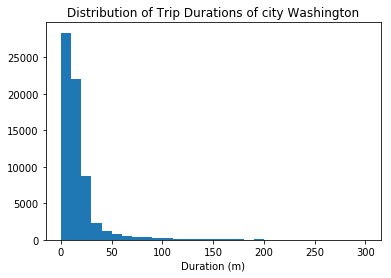

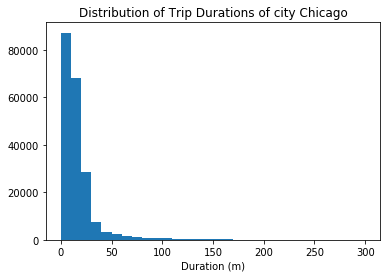

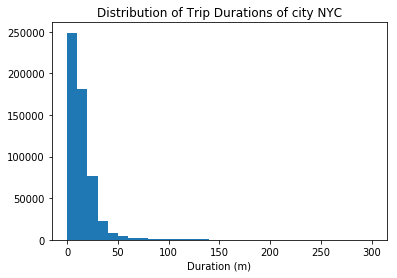

In [12]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed inline with the notebook.
%matplotlib inline 

data_duration = []
def data_trips(filename):
    """
    this function return the duration of every trip and the city which has this data
    """
    city = filename.split('-')[0].split('/')[-1]
    
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        for row in reader:
            data_duration.append(float(row['duration'])) # append the guration of the trip to list(data_duration)
    return data_duration,city

data_files = ['./data/Washington-2016-Summary.csv','./data/Chicago-2016-Summary.csv','./data/NYC-2016-Summary.csv']

for data_file in data_files:
    bins_edges = [0,10,20,30,40,50,60,70,80,90,100,
                110,120,130,140,150,160,170,180,190,200,
                210,220,230,240,250,260,270,280,290,300]
    plt.hist(data_trips(data_file)[0],bins = bins_edges)
    plt.title('Distribution of Trip Durations of city {}'.format(data_trips(data_file)[1]))
    plt.xlabel('Duration (m)')
    plt.show()


**Question 5**: Use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in your selected city. Do the same thing for only the Customers. Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, set the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?

**Answer**: the peak of the histogram'Distribution of Trip Durations of Subscribers' of city Washington is in interval [4,8] minutes.
the peak of the histogram'Distribution of Trip Durations of Customers' of city Washington is in interval [16,20] minutes.
the histograms of both(Subscribers and Customers) are right skewed histograms.

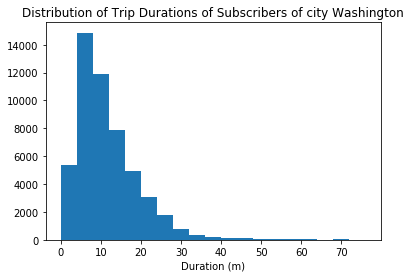

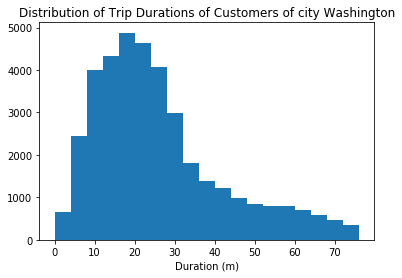

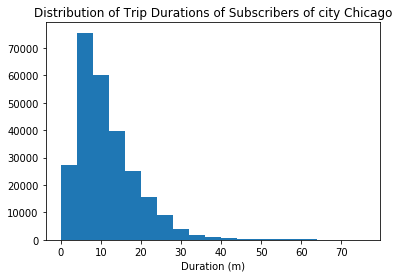

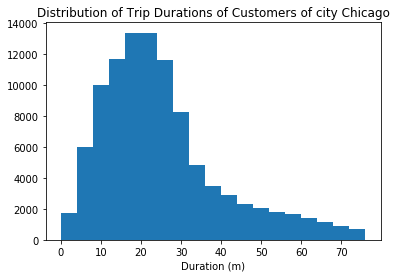

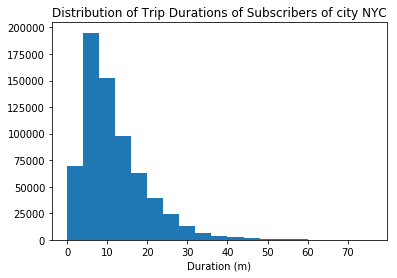

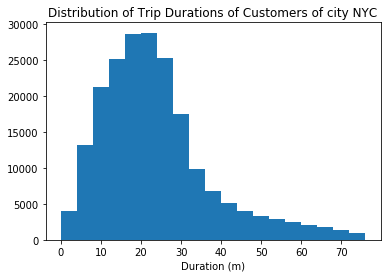

In [13]:
subscribers_duration = []
customers_duration = []
def hist_data_trips(filename):
	"""
	this function return the duration of trips which made by subscribers
	and the duration of trips which made by customers...duration of every trip must be less than 75 min
	"""
	city = filename.split('-')[0].split('/')[-1]

	with open(filename,'r') as f_in:
		# set up csv DictReader object
		reader = csv.DictReader(f_in)
		for row in reader: 
			if float(row['duration']) < 75: #if the duration of the trip < 75...we will append it to lists according to user type
				if row['user_type'] == 'Subscriber': # add duration of the trip if the user type is subscriber
					subscribers_duration.append(float(row['duration'])) 
				else: # add duration of the trip if the user type is customer
					customers_duration.append(float(row['duration']))
	return subscribers_duration,customers_duration,city


data_files = ['./data/Washington-2016-Summary.csv','./data/Chicago-2016-Summary.csv','./data/NYC-2016-Summary.csv']

for data_file in data_files:
	bins_edges = [0,4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76]
	plt.hist(hist_data_trips(data_file)[0],bins = bins_edges)
	plt.title('Distribution of Trip Durations of Subscribers of city {}'.format(hist_data_trips(data_file)[2]))
	plt.xlabel('Duration (m)')
	plt.show()

	plt.hist(hist_data_trips(data_file)[1],bins = bins_edges)
	plt.title('Distribution of Trip Durations of Customers of city {}'.format(hist_data_trips(data_file)[2]))
	plt.xlabel('Duration (m)')
	plt.show()

<a id='eda_continued'></a>
## Performing Your Own Analysis

So far, you've performed an initial exploration into the data available. You have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, you have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now it is your turn to continue the exploration in a direction that you choose. Here are a few suggestions for questions to explore:

- How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
- Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?
- During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?


**Question 6**: Continue the investigation by exploring another question that could be answered by the data available. Document the question you want to explore below. Your investigation should involve at least two variables and should compare at least two groups. You should also use at least one visualization as part of your explorations.

**Answer**: **Questions:**

1-How does ridership differ by month or season? Which month / season has the highest ridership? 

2-Does the ratio of Subscriber trips to Customer trips change depending on the month or season?



**Answer:**


**city (Washington) has:**

**the highest ridership in (summer) season [which is (21859)].**

the highest subscribes ridership in (summer) season [which is (16160)].

the highest customers ridership in (summer) season [which is (5699)].

**the highest ridership in month no.(7)  [which is (7341)].**

the highest subscribes ridership in month no.(6) [which is (5613)].

the highest customers ridership in month no.(7) [which is (2186)].



**city (Chicago) has :**

**the highest ridership in (summer) season [which is (29890)].**

the highest subscribes ridership in (summer) season [which is (21198)].

the highest customers ridership in (summer) season [which is (8692)].

**the highest ridership in month no.(7)  [which is (10286)].**

the highest subscribes ridership in month no.(6) [which is (7182)].

the highest customers ridership in month no.(7) [which is (3323)].



**city (NYC) has:**

**the highest ridership in (autumn) season [which is (88366)].**

the highest subscribes ridership in (autumn) season [which is (78554)].

the highest customers ridership in (summer) season [which is (11525)].

**the highest ridership in month no.(9)  [which is (32699)].**

the highest subscribes ridership in month no.(9) [which is (28306)].

the highest customers ridership in month no.(8) [which is (4412)].




**from polts::**

winter is the season which have the lowest ridership in the three cities.

summer is the season which have the hisghest ridership in the three cities.

months [12,1,2,3] has the lowest ridership in the three cities.

months [6,7,8,9] has the hisghest ridership in the three cities.

**Ans of Q2:**

**yes,the ratio of Subscriber trips to Customer trips change depending on the month and season as it seen in the polts**

winter has the highest ratio of Subscriber trips to Customer trips in the three cites.

summer has the lowest ratio of Subscriber trips to Customer trips in the three cites.

month no.(1) has the highest ratio of Subscriber trips to Customer trips in the three cites.

month no.(7) has the lowest ratio of Subscriber trips to Customer trips in the three cites.

city (Washington) has the highest ridership in (summer) season [which is (21859)].
city (Washington) has the highest subscribes ridership in (summer) season [which is (16160)].
city (Washington) has the highest customers ridership in (summer) season [which is (5699)].
city (Washington) has the highest ridership in month no.(7)  [which is (7341)].
city (Washington) has the highest subscribes ridership in month no.(6) [which is (5613)].
city (Washington) has the highest customers ridership in month no.(7) [which is (2186)].


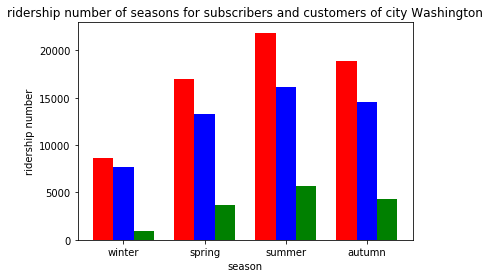

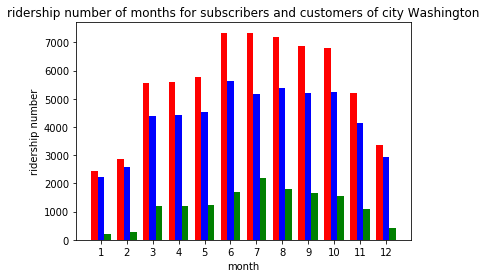

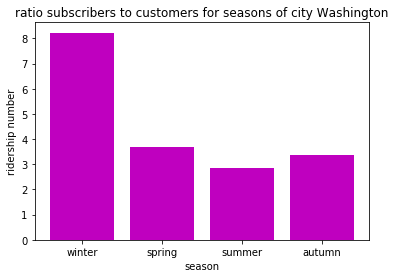

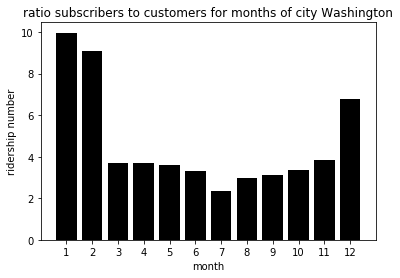

city (Chicago) has the highest ridership in (summer) season [which is (29890)].
city (Chicago) has the highest subscribes ridership in (summer) season [which is (21198)].
city (Chicago) has the highest customers ridership in (summer) season [which is (8692)].
city (Chicago) has the highest ridership in month no.(7)  [which is (10286)].
city (Chicago) has the highest subscribes ridership in month no.(6) [which is (7182)].
city (Chicago) has the highest customers ridership in month no.(7) [which is (3323)].


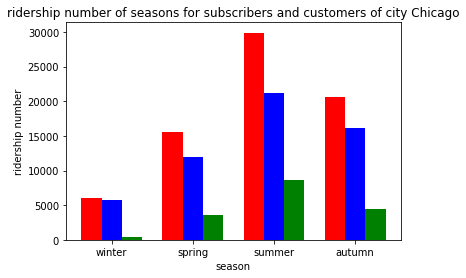

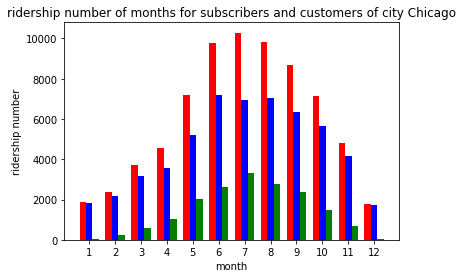

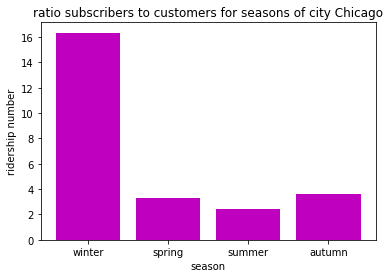

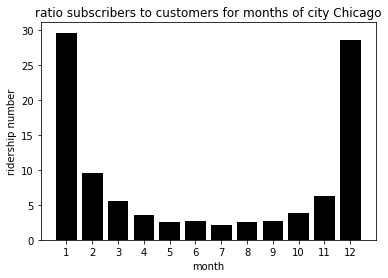

city (NYC) has the highest ridership in (autumn) season [which is (88366)].
city (NYC) has the highest subscribes ridership in (autumn) season [which is (78554)].
city (NYC) has the highest customers ridership in (summer) season [which is (11525)].
city (NYC) has the highest ridership in month no.(9)  [which is (32699)].
city (NYC) has the highest subscribes ridership in month no.(9) [which is (28306)].
city (NYC) has the highest customers ridership in month no.(8) [which is (4412)].


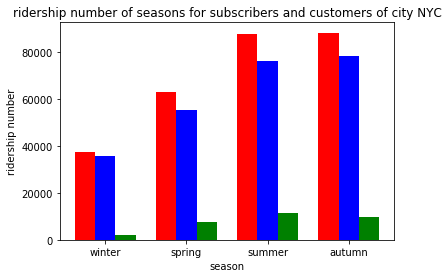

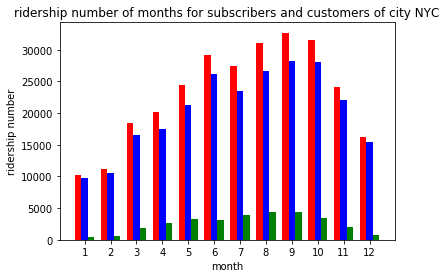

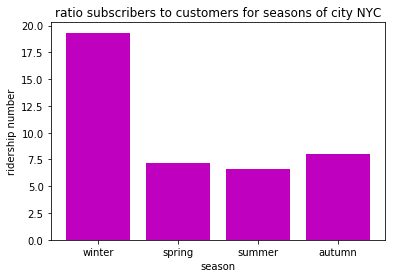

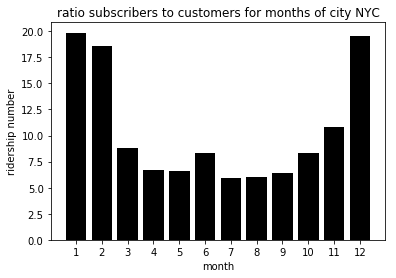

In [14]:
## Use this and additional cells to continue to explore the dataset. ##
## Once you have performed your exploration, document your findings  ##
## in the Markdown cell above.                                       ##

#How does ridership differ by month or season? Which month / season has the highest ridership? 
#Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
import matplotlib.pyplot as plt
%matplotlib inline

def season_and_months_trips(filename):
	"""
	this function return:
	the total number of trips made by riders for every season.
	the total number of trips made by subscribers for every season.
	the total number of trips made by customers for every season.
	the ratio of Subscriber trips to Customer trips for every season.
	the total number of trips made by riders for every month.
	the total number of trips made by subscribers for every month.
	the total number of trips made by customers for every month.
	the ratio of Subscriber trips to Customer trips for every month.
	"""
	n_subs_winter = 0 #the number of subscriber ridership of winter
	n_cust_winter = 0 #the number of customer ridership of winter
	n_subs_summer = 0 #the number of subscriber ridership of summer
	n_cust_summer = 0 #the number of customer ridership of summer
	n_subs_autumn = 0 #the number of subscriber ridership of autumn
	n_cust_autumn = 0 #the number of customer ridership of autumn
	n_subs_spring = 0 #the number of subscriber ridership of apring
	n_cust_spring = 0 #the number of customer ridership of spring

	n_subs_month = {'1': 0,'2': 0,'3': 0,'4': 0,'5': 0,'6': 0,'7': 0,'8': 0,'9': 0,'10': 0,'11': 0,'12': 0}
	#the number of subscribers ridership of every month
	n_cust_month = {'1': 0,'2': 0,'3': 0,'4': 0,'5': 0,'6': 0,'7': 0,'8': 0,'9': 0,'10': 0,'11': 0,'12': 0}
	#the number of customers ridership of every month


	with open(filename,'r') as f_in:
		#open data file and read it
		reader = csv.DictReader(f_in)


		for row in reader:
			if row['user_type'] == 'Subscriber':
			#if user_type is Subscriber...we will add 1 to the number of subscriber ridership number according to seasons
				if float(row['month']) in [12,1,2]: # months(12,1,2) are in winter season
					n_subs_winter += 1
				elif float(row['month']) in [3,4,5]: # months(3,4,5) are in spring season
					n_subs_spring += 1
				elif float(row['month']) in [6,7,8]: # months(6,7,8) are in summer season
					n_subs_summer += 1
				else:   # months(9,10,11) are in autumn season
					n_subs_autumn += 1

				for month in range(12): 
					#if user_type is Subscriber...we will add 1 to the number of subscriber ridership number according to months
					if float(row['month']) == (month + 1):
						n_subs_month[str(month + 1)] += 1


			else:
			#if user_type is Customer...we will add 1 to the number of customer ridership number according to seasons
				if float(row['month']) in [12,1,2]: # months(12,1,2) are in winter season
					n_cust_winter += 1
				elif float(row['month']) in [3,4,5]: # months(3,4,5) are in spring season
					n_cust_spring += 1
				elif float(row['month']) in [6,7,8]: # months(6,7,8) are in summer season
					n_cust_summer += 1
				else:   # months(9,10,11) are in autumn season
					n_cust_autumn += 1

				for month in range(12):
					#if user_type is Customer...we will add 1 to the number of customer ridership number according to months
					if float(row['month']) == (month + 1):
						n_cust_month[str(month + 1)] += 1




	n_subs_season = {'winter': n_subs_winter,'spring': n_subs_spring,'summer': n_subs_summer,'autumn': n_subs_autumn} #Dict of seasons as keys and the number of all trips(made by subscribers) as values
	n_cust_season = {'winter': n_cust_winter,'spring': n_cust_spring,'summer': n_cust_summer,'autumn': n_cust_autumn} #Dict of seasons as keys and the number of all trips(made by customers) as values

	n_total_winter = n_subs_winter + n_cust_winter #all trips in winter season
	n_total_summer = n_subs_summer + n_cust_summer #all trips in summer season
	n_total_autumn = n_subs_autumn + n_cust_autumn #all trips in autumn season
	n_total_spring = n_subs_spring + n_cust_spring #all trips in spring season

	n_total_season = {'winter': n_total_winter,'spring': n_total_spring,'summer': n_total_summer,'autumn': n_total_autumn} #Dict of seasons as keys and the number of all trips as values

	ratio_subs_to_cust_winter = n_subs_winter / n_cust_winter
	ratio_subs_to_cust_summer = n_subs_summer / n_cust_summer
	ratio_subs_to_cust_autumn = n_subs_autumn / n_cust_autumn
	ratio_subs_to_cust_spring = n_subs_spring / n_cust_spring

	ratio_subs_to_cust_season = {'winter': ratio_subs_to_cust_winter,'spring': ratio_subs_to_cust_spring,'summer': ratio_subs_to_cust_summer,'autumn': ratio_subs_to_cust_autumn}
	#Dict of seasons as keys and the ratio of subscribers trips to customers trips as values.

	n_total_month = {'1': 0,'2': 0,'3': 0,'4': 0,'5': 0,'6': 0,'7': 0,'8': 0,'9': 0,'10': 0,'11': 0,'12': 0} #Dict of months as keys and the number of all trips as values
	ratio_subs_to_cust_month = {'1': 0,'2': 0,'3': 0,'4': 0,'5': 0,'6': 0,'7': 0,'8': 0,'9': 0,'10': 0,'11': 0,'12': 0} #Dict of months as keys and the ratio of subscribers trips to customers trips as values.
	for month in range(12): #make dicts for n_total_trips and ratio subscribers to customers.
		n_total_month[str(month + 1)] = n_subs_month[str(month + 1)] + n_cust_month[str(month + 1)]
		ratio_subs_to_cust_month[str(month + 1)] = n_subs_month[str(month + 1)] / n_cust_month[str(month + 1)]




	return(n_total_season , n_subs_season , n_cust_season , ratio_subs_to_cust_season,
		n_total_month , n_subs_month , n_cust_month , ratio_subs_to_cust_month)

#######
data_files = ['./data/Washington-2016-Summary.csv','./data/Chicago-2016-Summary.csv','./data/NYC-2016-Summary.csv']
for data_file in data_files:
	city = data_file.split('-')[0].split('/')[-1]

	## the maximum ridership for subscribers and customers in seasons ##
	max_total_seasons = max(season_and_months_trips(data_file)[0], key=season_and_months_trips(data_file)[0].get)
	max_subs_seasons = max(season_and_months_trips(data_file)[1], key=season_and_months_trips(data_file)[1].get)
	max_cust_seasons = max(season_and_months_trips(data_file)[2], key=season_and_months_trips(data_file)[2].get)

	## the maximum ridership for subscribers and customers in months ##
	max_total_months = max(season_and_months_trips(data_file)[4], key=season_and_months_trips(data_file)[4].get)
	max_subs_months = max(season_and_months_trips(data_file)[5], key=season_and_months_trips(data_file)[5].get)
	max_cust_months = max(season_and_months_trips(data_file)[6], key=season_and_months_trips(data_file)[6].get)


	print('city ({}) has the highest ridership in ({}) season [which is ({})].'
		.format(city,max_total_seasons,season_and_months_trips(data_file)[0][max_total_seasons]))
	print('city ({}) has the highest subscribes ridership in ({}) season [which is ({})].'
		.format(city,max_subs_seasons,season_and_months_trips(data_file)[1][max_subs_seasons]))
	print('city ({}) has the highest customers ridership in ({}) season [which is ({})].'
		.format(city,max_cust_seasons,season_and_months_trips(data_file)[2][max_cust_seasons]))

	print('city ({}) has the highest ridership in month no.({})  [which is ({})].'
		.format(city,max_total_months,season_and_months_trips(data_file)[4][max_total_months]))
	print('city ({}) has the highest subscribes ridership in month no.({}) [which is ({})].'
		.format(city,max_subs_months,season_and_months_trips(data_file)[5][max_subs_months]))
	print('city ({}) has the highest customers ridership in month no.({}) [which is ({})].'
		.format(city,max_cust_months,season_and_months_trips(data_file)[6][max_cust_months]))


	## polting the number of ridership of total_trips,subscribers and customers for every season##
	plt.bar([1,5,9,13], list(season_and_months_trips(data_file)[0].values()),width=1,color='r')
	plt.bar([2,6,10,14], list(season_and_months_trips(data_file)[1].values()),width=1,color='b')
	plt.bar([3,7,11,15], list(season_and_months_trips(data_file)[2].values()),width=1,color='g')
	plt.xticks([2,6,10,14],list(season_and_months_trips(data_file)[2].keys()))
	plt.title('ridership number of seasons for subscribers and customers of city {}'.format(city))
	plt.xlabel('season')
	plt.ylabel('ridership number')
	plt.show()

	## polting the number of ridership of total_trips,subscribers and customers for every month##
	plt.bar([1,3,5,7,9,11,13,15,17,19,21,23],list(season_and_months_trips(data_file)[4].values()),width=0.5,color='r')
	plt.bar([1.5,3.5,5.5,7.5,9.5,11.5,13.5,15.5,17.5,19.5,21.5,23.5],list(season_and_months_trips(data_file)[5].values()),width=0.5,color='b')
	plt.bar([2,4,6,8,10,12,14,16,18,20,22,24],list(season_and_months_trips(data_file)[6].values()),width=0.5,color='g')
	plt.xticks([1.5,3.5,5.5,7.5,9.5,11.5,13.5,15.5,17.5,19.5,21.5,23.5],list(season_and_months_trips(data_file)[6].keys()))
	plt.title('ridership number of months for subscribers and customers of city {}'.format(city))
	plt.xlabel('month')
	plt.ylabel('ridership number')
	plt.show()

	## polting the ratio of subscribers trips to customers for every season##
	plt.bar(range(4), list(season_and_months_trips(data_file)[3].values()),color='m')
	plt.xticks(range(4),list(season_and_months_trips(data_file)[3].keys()))
	plt.title('ratio subscribers to customers for seasons of city {}'.format(city))
	plt.xlabel('season')
	plt.ylabel('ridership number')
	plt.show()

	## polting the ratio of subscribers trips to customers for every month##
	plt.bar(range(12), list(season_and_months_trips(data_file)[7].values()),color='k')
	plt.xticks(range(12),list(season_and_months_trips(data_file)[7].keys()))
	plt.title('ratio subscribers to customers for months of city {}'.format(city))
	plt.xlabel('month')
	plt.ylabel('ridership number')
	plt.show()

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, you might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

**Question 7**: Putting the bike share data aside, think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**: **I am intersted to apply data analysis techniques in business field**...I want to be able to use these techniques to answer these questions:
 
what is the most required product or sevice in the global market,local market and digital market?

what is the highest country or area in sales of the product or the service?

how does the level of sales differ from month to month or from season to season?

what are the ages of people who are interested in buying the product or the sevice?

how will the level of sales be affected if we raise the price but with some more offers for people will buy more?

what is the average of sales every year(that is required to investigate about the reasons which made the average high or low)?

which companies should we deal with by analysing its available data?

how could the political and economical situation affect the people's ability to buy the product or the sevice?

and many other questions about the specified details in the product or the service.

In [15]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0